#  Task 2 - Implementation and fine-tuning of vision transformer

Implementation and fine-tuning of a vision transformer for img classification

This implementation took inspiration from the following [resource](https://huggingface.co/blog/fine-tune-vit)

In [2]:
# Import of all used libs
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
from transformers import ViTForImageClassification, ViTImageProcessor, TrainingArguments, Trainer
from datasets import load_dataset
from transformers import ViTFeatureExtractor
import random
from PIL import Image, ImageDraw
import evaluate
import numpy as np

In [3]:
# Cuda avail check
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce GTX 1650
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


## Part a. CIFAR-10 Loading and pre-processing

...

In [4]:
cifar10 = load_dataset('cifar10')
cifar10

c:\Users\LEGION\anaconda3\envs\AML-CV\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\LEGION\.cache\huggingface\hub\datasets--cifar10. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Generating test split: 100%|██████████| 10000/10000 [00:00<00:00, 101200.71 examples/s]


DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

In [5]:
from PIL import ImageFont

def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(350, 350)):

    w, h = size
    labels = ds['train'].features['label'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype('./LiberationMono-Bold.ttf', size=24)

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['label'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['img']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255), font=font)

    return grid

In [8]:
show_examples(cifar10, seed=random.randint(0, 1337), examples_per_class=3)

OSError: cannot open resource

The images are being preprocessed by resizing them to 224x224 pixels, which is the required input size for the Vision Transformer (ViT). The `ViTImageProcessor` handles the following steps:

1. **Resizing**: Images are resized to 224x224 using bilinear interpolation (`resample=2`).
2. **Rescaling**: Pixel values are rescaled by a factor of 1/255 (`rescale_factor = 0.00392156862745098`), bringing them into the range [0, 1].
3. **Normalization**: Standard normalization is applied using the following mean and standard deviation:
   - `image_mean = [0.5, 0.5, 0.5]`
   - `image_std = [0.5, 0.5, 0.5]`
   This normalizes each channel (RGB) to have a mean of 0 and a standard deviation of 1.

The transform function processes batches of images by converting them into PyTorch tensors and applying these preprocessing steps lazily, the preprocessor is obtained from the authors of the model I'm using.

In [6]:
# Pre-processing of the dataset
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [7]:
# Function to apply the processor on each img
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = processor([x for x in example_batch['img']], return_tensors='pt') #pt means pytorch tensor
    inputs['label'] = example_batch['label']
    return inputs

prepared_cifar10 = cifar10.with_transform(transform)

In [8]:
prepared_cifar10['train'][0:2]

{'pixel_values': tensor([[[[ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          [ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          [ 0.3961,  0.3961,  0.3961,  ...,  0.2941,  0.2941,  0.2941],
          ...,
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863],
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863],
          [-0.1922, -0.1922, -0.1922,  ..., -0.2863, -0.2863, -0.2863]],

         [[ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          [ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          [ 0.3804,  0.3804,  0.3804,  ...,  0.2784,  0.2784,  0.2784],
          ...,
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412, -0.3412, -0.3412],
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412, -0.3412, -0.3412],
          [-0.2471, -0.2471, -0.2471,  ..., -0.3412, -0.3412, -0.3412]],

         [[ 0.4824,  0.4824,  0.4824,  ...,  0.3647,  0.3647,  0.3647],
          [ 0

## Part b. - Load Pre-Trained ViT model

In [9]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

metric = evaluate.load('accuracy')
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

In [10]:
labels = cifar10['train'].features['label'].names

model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)
model.to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

## Part c. - Model Fine-Tuning

### Layer freezing

To prevent overfitting layers $0 - 9$ where frozen, the training was done only in the last 2 layers $+$ the classifier.





In [11]:
# Freezing of layers we don't want to train
for name, param in model.named_parameters():
    if "encoder.layer" in name:
        layer_number = int(name.split('.')[3])
        if layer_number < 10:  # Freeze layers 0-9, keep the last 2 
            param.requires_grad = False

for name, param in model.named_parameters():
    print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")

# Definition of training args
training_args = TrainingArguments(
  output_dir="./vit-base-beans",
  per_device_train_batch_size=32,
  eval_strategy="epoch",
  save_strategy="epoch",
  optim="adamw_torch",
  lr_scheduler_type="linear", # 
  num_train_epochs=3, # 3 epoch(s) to prevent overfitting
  fp16=True, # Mixed 16 bit floating precision
  save_steps=1000,
  eval_steps=1000,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False, # Note 
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

vit.embeddings.cls_token: Trainable
vit.embeddings.position_embeddings: Trainable
vit.embeddings.patch_embeddings.projection.weight: Trainable
vit.embeddings.patch_embeddings.projection.bias: Trainable
vit.encoder.layer.0.attention.attention.query.weight: Frozen
vit.encoder.layer.0.attention.attention.query.bias: Frozen
vit.encoder.layer.0.attention.attention.key.weight: Frozen
vit.encoder.layer.0.attention.attention.key.bias: Frozen
vit.encoder.layer.0.attention.attention.value.weight: Frozen
vit.encoder.layer.0.attention.attention.value.bias: Frozen
vit.encoder.layer.0.attention.output.dense.weight: Frozen
vit.encoder.layer.0.attention.output.dense.bias: Frozen
vit.encoder.layer.0.intermediate.dense.weight: Frozen
vit.encoder.layer.0.intermediate.dense.bias: Frozen
vit.encoder.layer.0.output.dense.weight: Frozen
vit.encoder.layer.0.output.dense.bias: Frozen
vit.encoder.layer.0.layernorm_before.weight: Frozen
vit.encoder.layer.0.layernorm_before.bias: Frozen
vit.encoder.layer.0.layern

In [12]:
# Training
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_cifar10["train"],
    eval_dataset=prepared_cifar10["test"],
    tokenizer=processor,
)

In [13]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics ) 

trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.090200,0.091320,0.971900
2,0.048700,0.072549,0.978600
3,0.015400,0.066692,0.982200


***** train metrics *****
  epoch                    =           3.0
  total_flos               = 10826282096GF
  train_loss               =        0.0754
  train_runtime            =    0:08:39.50
  train_samples_per_second =       288.737
  train_steps_per_second   =         9.026


In [14]:
# Eval block
metrics = trainer.evaluate(prepared_cifar10['test'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        3.0
  eval_accuracy           =     0.9822
  eval_loss               =     0.0667
  eval_runtime            = 0:00:34.40
  eval_samples_per_second =    290.685
  eval_steps_per_second   =     36.336


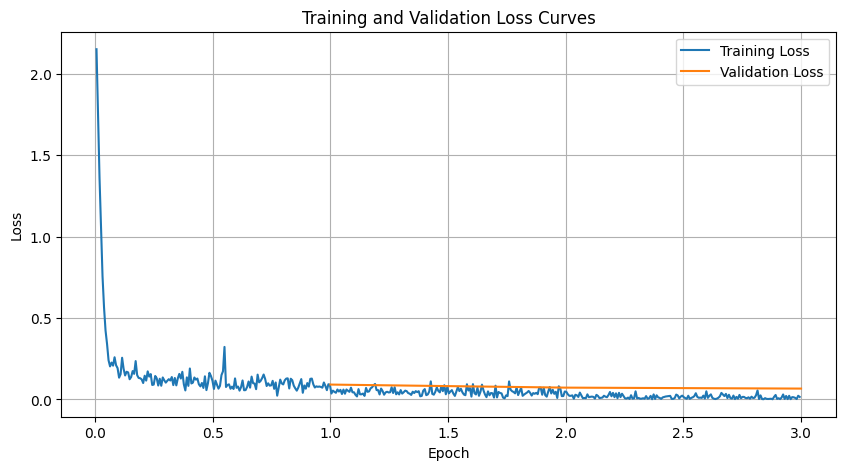

In [15]:
# Training Curve Visualization

log_history = trainer.state.log_history
train_loss = []
eval_loss = []
train_accuracy = []
eval_accuracy = []
train_steps = []
eval_steps = []

for log in log_history:
    if 'loss' in log.keys() and 'epoch' in log.keys():
        train_loss.append(log['loss'])
        train_steps.append(log['epoch']) 
    if 'eval_loss' in log.keys():
        eval_loss.append(log['eval_loss'])
        eval_steps.append(log['epoch'])
    if 'eval_accuracy' in log.keys():
        eval_accuracy.append(log['eval_accuracy'])

plt.figure(figsize=(10, 5))
plt.plot(train_steps, train_loss, label='Training Loss')
plt.plot(eval_steps, eval_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

## f. Attention map visualization (and infer test)

Vision Transformers (ViTs) use self-attention mechanisms to focus on different parts of an image for classification. Attention maps visualize how much each patch in the image influences the model’s decision. These maps show which regions the model considers most important when making a prediction.

In ViTs, the image is split into fixed-size patches (e.g., 16x16 pixels), which are then linearly embedded. Each patch interacts with every other patch through multi-head self-attention, allowing the model to capture both local and global relationships across the image.

In [35]:
vit_model = ViTForImageClassification.from_pretrained("./vit-base-beans")
vit_model.eval()
vit_model.config.output_attentions = True
vit_model.to(device)

original_sample = cifar10['test'][20]
image = original_sample['img']
label = original_sample['label']
    
inputs = processor(images=image, return_tensors="pt")
inputs = {k: v.to(model.device) for k, v in inputs.items()}
    
# Forward pass
with torch.no_grad():
    outputs = vit_model(**inputs, output_attentions=True)

print(f"Model outputs (logits): {outputs.logits}")

predicted_label = torch.argmax(outputs.logits, dim=-1)
print(f'Predicted label: {predicted_label.item()}, Actual label: {label}')

attentions = outputs.attentions  # Tuple of (num_layers, batch_size, num_heads, seq_len, seq_len)
print("Attentions: ", attentions) # Attentions list is full of None for some reason...
attention = attentions[-1]       # Shape: (batch_size, num_heads, seq_len, seq_len)
    
attention = attention.mean(dim=1)  # Shape: (batch_size, seq_len, seq_len)

Model outputs (logits): tensor([[-1.4523, -0.9883, -1.7749, -1.0151, -1.0336,  0.5870, -1.1491,  8.6559,
         -1.3704, -0.6770]], device='cuda:0')
Predicted label: 7, Actual label: 7
Attentions:  (None, None, None, None, None, None, None, None, None, None, None, None)


AttributeError: 'NoneType' object has no attribute 'mean'

In [7]:
import torch.nn.functional as F
cls_attention = attention[:, 0, 1:]  # Shape: (batch_size, seq_len - 1)
    
# Reshape attention map to 2D spatial dimensions
num_patches = int(np.sqrt(cls_attention.shape[-1]))
cls_attention = cls_attention.reshape(-1, num_patches, num_patches)
    
# Upsample the attention map to the image size
cls_attention = F.interpolate(cls_attention.unsqueeze(1), size=(image.size[1], image.size[0]), mode='bilinear', align_corners=False)
cls_attention = cls_attention.squeeze().cpu().numpy()
    
# Normalize attention map for visualization
cls_attention = (cls_attention - cls_attention.min()) / (cls_attention.max() - cls_attention.min())
    
# Plot the original image and attention map
plt.figure(figsize=(12, 6))
    
# Original Image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title(f'Original Image - Label: {label}')
plt.axis('off')
    
# Attention Map Overlay
plt.subplot(1, 2, 2)
plt.imshow(image)
plt.imshow(cls_attention, cmap='jet', alpha=0.5)
plt.title('Attention Map Overlay')
plt.axis('off')
    
plt.show()

NameError: name 'attention' is not defined